# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

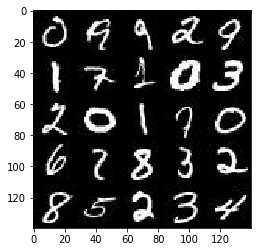

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

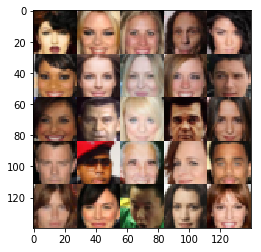

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, 
                                 [None, image_width, image_height, image_channels], 
                                 name='real_input')
    
    z_inputs = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    
    learning_rate = tf.placeholder(tf.float32)

    return (real_inputs, z_inputs, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    keep_prob = 0.7
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x(1, 3)
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(x1*alpha, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.layers.dropout(x2, rate=keep_prob)
        relu2 = tf.maximum(x2*alpha, x2)

        #7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.layers.dropout(x3, rate=keep_prob)
        relu3 = tf.maximum(x3*alpha, x3)
        # 7x7x512
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.layers.dropout(x4, rate=keep_prob)
        relu4 = tf.maximum(x4*alpha, x4)
        
        #flatten it
        flat = tf.reshape(relu4, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

    return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # FC
        x1 = tf.layers.dense(z, 7*7*512)
        #reshape for convStack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*alpha, x2)
        # 14x14x512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3*alpha, x3)
        # 14x14x256
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4*alpha, x4)
        # 14x14x128
        
        #output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                           labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                           labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return (d_loss, g_loss)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, 
                                                                                  var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,
                                                                                 var_list=g_vars)
    
    return (d_train_opt, g_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    show_every = 100
    print_every = 10
    num_images = 32
    
    num_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                # random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run opt
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:    
                    show_generator_output(sess, num_images, input_z, channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.2823... Generator Loss: 2.4588
Epoch 0/2... Discriminator Loss: 1.0259... Generator Loss: 1.3450
Epoch 0/2... Discriminator Loss: 0.7178... Generator Loss: 2.3647
Epoch 0/2... Discriminator Loss: 0.9529... Generator Loss: 1.9576
Epoch 0/2... Discriminator Loss: 1.6416... Generator Loss: 0.3717
Epoch 0/2... Discriminator Loss: 1.0285... Generator Loss: 1.7219
Epoch 0/2... Discriminator Loss: 0.9232... Generator Loss: 1.3967
Epoch 0/2... Discriminator Loss: 2.0138... Generator Loss: 0.4167
Epoch 0/2... Discriminator Loss: 1.3475... Generator Loss: 0.5691
Epoch 0/2... Discriminator Loss: 2.4174... Generator Loss: 1.8054


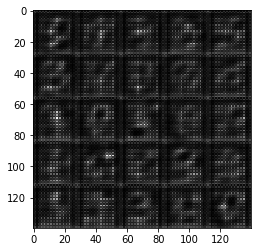

Epoch 0/2... Discriminator Loss: 1.6116... Generator Loss: 0.4665
Epoch 0/2... Discriminator Loss: 1.5896... Generator Loss: 0.4650
Epoch 0/2... Discriminator Loss: 1.6398... Generator Loss: 0.3446
Epoch 0/2... Discriminator Loss: 1.1035... Generator Loss: 1.0192
Epoch 0/2... Discriminator Loss: 1.6307... Generator Loss: 0.9172
Epoch 0/2... Discriminator Loss: 1.4632... Generator Loss: 0.7899
Epoch 0/2... Discriminator Loss: 1.2190... Generator Loss: 0.7607
Epoch 0/2... Discriminator Loss: 1.6057... Generator Loss: 0.3503
Epoch 0/2... Discriminator Loss: 1.3259... Generator Loss: 0.5416
Epoch 0/2... Discriminator Loss: 1.7649... Generator Loss: 2.0561


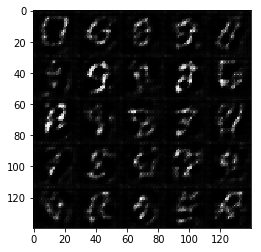

Epoch 0/2... Discriminator Loss: 1.1921... Generator Loss: 0.8775
Epoch 0/2... Discriminator Loss: 1.6136... Generator Loss: 0.7261
Epoch 0/2... Discriminator Loss: 1.4814... Generator Loss: 1.0306
Epoch 0/2... Discriminator Loss: 1.6525... Generator Loss: 1.9659
Epoch 0/2... Discriminator Loss: 1.2643... Generator Loss: 1.3423
Epoch 0/2... Discriminator Loss: 1.4243... Generator Loss: 0.9310
Epoch 0/2... Discriminator Loss: 1.4055... Generator Loss: 0.4761
Epoch 0/2... Discriminator Loss: 1.3452... Generator Loss: 1.5345
Epoch 0/2... Discriminator Loss: 1.2549... Generator Loss: 0.6527
Epoch 0/2... Discriminator Loss: 1.7985... Generator Loss: 0.2961


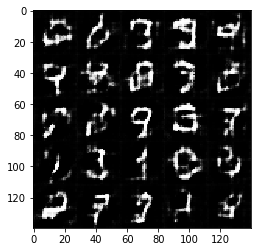

Epoch 0/2... Discriminator Loss: 1.5267... Generator Loss: 1.6271
Epoch 0/2... Discriminator Loss: 1.3042... Generator Loss: 0.9765
Epoch 0/2... Discriminator Loss: 1.8169... Generator Loss: 1.3185
Epoch 0/2... Discriminator Loss: 1.3550... Generator Loss: 0.8608
Epoch 0/2... Discriminator Loss: 1.6904... Generator Loss: 0.2924
Epoch 0/2... Discriminator Loss: 1.1101... Generator Loss: 0.9093
Epoch 0/2... Discriminator Loss: 1.0977... Generator Loss: 0.7925
Epoch 0/2... Discriminator Loss: 1.4248... Generator Loss: 0.5117
Epoch 0/2... Discriminator Loss: 1.2607... Generator Loss: 0.7687
Epoch 0/2... Discriminator Loss: 1.2546... Generator Loss: 1.0300


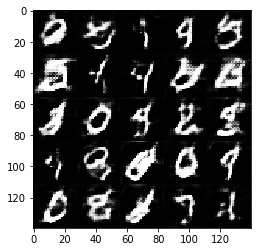

Epoch 0/2... Discriminator Loss: 1.6472... Generator Loss: 0.3333
Epoch 0/2... Discriminator Loss: 1.2984... Generator Loss: 0.5495
Epoch 0/2... Discriminator Loss: 1.2345... Generator Loss: 0.7346
Epoch 0/2... Discriminator Loss: 1.4341... Generator Loss: 0.8649
Epoch 0/2... Discriminator Loss: 1.8234... Generator Loss: 0.2560
Epoch 0/2... Discriminator Loss: 1.1828... Generator Loss: 0.8815
Epoch 0/2... Discriminator Loss: 1.0622... Generator Loss: 0.8296
Epoch 0/2... Discriminator Loss: 1.5452... Generator Loss: 0.5591
Epoch 0/2... Discriminator Loss: 1.1974... Generator Loss: 1.3049
Epoch 0/2... Discriminator Loss: 1.1018... Generator Loss: 0.8286


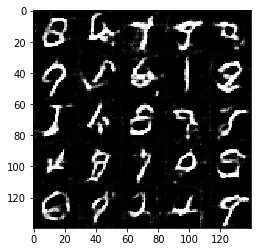

Epoch 0/2... Discriminator Loss: 1.1870... Generator Loss: 0.9619
Epoch 0/2... Discriminator Loss: 1.1013... Generator Loss: 0.9926
Epoch 0/2... Discriminator Loss: 1.5850... Generator Loss: 0.4004
Epoch 0/2... Discriminator Loss: 1.1821... Generator Loss: 0.9703
Epoch 0/2... Discriminator Loss: 1.1003... Generator Loss: 0.8305
Epoch 0/2... Discriminator Loss: 1.2442... Generator Loss: 1.6742
Epoch 0/2... Discriminator Loss: 1.5156... Generator Loss: 0.4723
Epoch 0/2... Discriminator Loss: 1.0303... Generator Loss: 1.5331
Epoch 0/2... Discriminator Loss: 1.0515... Generator Loss: 1.3252
Epoch 0/2... Discriminator Loss: 1.3853... Generator Loss: 0.4751


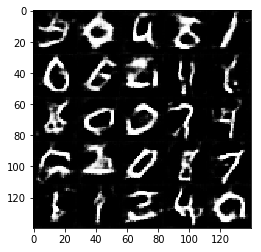

Epoch 0/2... Discriminator Loss: 1.3100... Generator Loss: 0.5890
Epoch 0/2... Discriminator Loss: 1.9059... Generator Loss: 2.4224
Epoch 0/2... Discriminator Loss: 1.2178... Generator Loss: 0.9812
Epoch 0/2... Discriminator Loss: 1.1073... Generator Loss: 0.8220
Epoch 0/2... Discriminator Loss: 1.1846... Generator Loss: 0.8492
Epoch 0/2... Discriminator Loss: 1.0336... Generator Loss: 0.9472
Epoch 0/2... Discriminator Loss: 1.1768... Generator Loss: 1.2145
Epoch 0/2... Discriminator Loss: 1.2133... Generator Loss: 0.5945
Epoch 0/2... Discriminator Loss: 1.1546... Generator Loss: 1.2070
Epoch 0/2... Discriminator Loss: 1.3007... Generator Loss: 0.4744


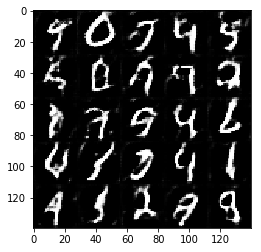

Epoch 0/2... Discriminator Loss: 1.9688... Generator Loss: 0.2577
Epoch 0/2... Discriminator Loss: 0.9836... Generator Loss: 1.0345
Epoch 0/2... Discriminator Loss: 1.5232... Generator Loss: 0.3977
Epoch 0/2... Discriminator Loss: 1.2070... Generator Loss: 0.7600
Epoch 0/2... Discriminator Loss: 1.1125... Generator Loss: 0.7775
Epoch 0/2... Discriminator Loss: 0.9293... Generator Loss: 1.0189
Epoch 0/2... Discriminator Loss: 1.0973... Generator Loss: 0.7623
Epoch 0/2... Discriminator Loss: 1.0975... Generator Loss: 0.7507
Epoch 0/2... Discriminator Loss: 1.6263... Generator Loss: 2.6942
Epoch 0/2... Discriminator Loss: 1.2869... Generator Loss: 1.6805


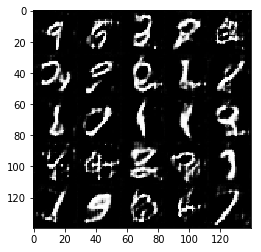

KeyboardInterrupt: 

In [21]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.4940... Generator Loss: 25.5343
Epoch 0/1... Discriminator Loss: 0.7867... Generator Loss: 9.7839
Epoch 0/1... Discriminator Loss: 2.3548... Generator Loss: 2.8991
Epoch 0/1... Discriminator Loss: 0.7066... Generator Loss: 2.7513
Epoch 0/1... Discriminator Loss: 2.1912... Generator Loss: 0.4143
Epoch 0/1... Discriminator Loss: 0.7121... Generator Loss: 1.3949
Epoch 0/1... Discriminator Loss: 0.7983... Generator Loss: 2.3045
Epoch 0/1... Discriminator Loss: 1.4232... Generator Loss: 1.6148
Epoch 0/1... Discriminator Loss: 0.8711... Generator Loss: 1.5849
Epoch 0/1... Discriminator Loss: 2.9110... Generator Loss: 5.9217


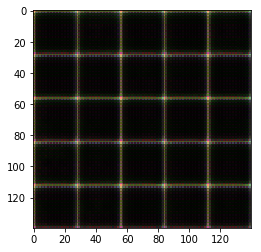

Epoch 0/1... Discriminator Loss: 1.8175... Generator Loss: 0.3503
Epoch 0/1... Discriminator Loss: 1.2442... Generator Loss: 0.9976
Epoch 0/1... Discriminator Loss: 0.9817... Generator Loss: 0.9157
Epoch 0/1... Discriminator Loss: 0.8201... Generator Loss: 1.6548
Epoch 0/1... Discriminator Loss: 1.7467... Generator Loss: 0.3665
Epoch 0/1... Discriminator Loss: 1.0266... Generator Loss: 0.8914
Epoch 0/1... Discriminator Loss: 1.3243... Generator Loss: 0.8021
Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.8775
Epoch 0/1... Discriminator Loss: 1.5095... Generator Loss: 0.6313
Epoch 0/1... Discriminator Loss: 1.2618... Generator Loss: 0.5154


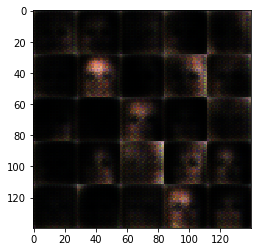

Epoch 0/1... Discriminator Loss: 1.4957... Generator Loss: 0.4383
Epoch 0/1... Discriminator Loss: 0.9749... Generator Loss: 0.7956
Epoch 0/1... Discriminator Loss: 1.4206... Generator Loss: 0.4139
Epoch 0/1... Discriminator Loss: 1.4294... Generator Loss: 0.4791
Epoch 0/1... Discriminator Loss: 1.1520... Generator Loss: 0.8514
Epoch 0/1... Discriminator Loss: 1.6075... Generator Loss: 0.4737
Epoch 0/1... Discriminator Loss: 1.0891... Generator Loss: 0.9364
Epoch 0/1... Discriminator Loss: 1.4630... Generator Loss: 0.4057
Epoch 0/1... Discriminator Loss: 1.1638... Generator Loss: 0.9781
Epoch 0/1... Discriminator Loss: 1.8569... Generator Loss: 0.3160


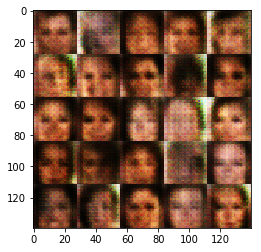

Epoch 0/1... Discriminator Loss: 1.4700... Generator Loss: 0.5148
Epoch 0/1... Discriminator Loss: 1.1013... Generator Loss: 0.6021
Epoch 0/1... Discriminator Loss: 1.3422... Generator Loss: 0.8264
Epoch 0/1... Discriminator Loss: 1.4094... Generator Loss: 0.4946
Epoch 0/1... Discriminator Loss: 1.3456... Generator Loss: 1.5936
Epoch 0/1... Discriminator Loss: 1.5800... Generator Loss: 0.6473
Epoch 0/1... Discriminator Loss: 1.2003... Generator Loss: 0.5962
Epoch 0/1... Discriminator Loss: 0.9099... Generator Loss: 0.8837
Epoch 0/1... Discriminator Loss: 1.2176... Generator Loss: 0.8280
Epoch 0/1... Discriminator Loss: 1.8601... Generator Loss: 1.7710


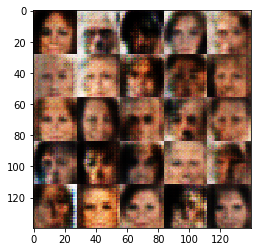

Epoch 0/1... Discriminator Loss: 1.1201... Generator Loss: 0.6286
Epoch 0/1... Discriminator Loss: 1.4187... Generator Loss: 0.7479
Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 0.7590
Epoch 0/1... Discriminator Loss: 1.2162... Generator Loss: 0.6503
Epoch 0/1... Discriminator Loss: 1.7429... Generator Loss: 0.3257
Epoch 0/1... Discriminator Loss: 1.0093... Generator Loss: 1.2201
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 0.6818
Epoch 0/1... Discriminator Loss: 1.3553... Generator Loss: 0.6818
Epoch 0/1... Discriminator Loss: 1.4168... Generator Loss: 0.5144
Epoch 0/1... Discriminator Loss: 1.2110... Generator Loss: 0.7209


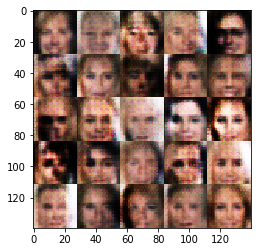

Epoch 0/1... Discriminator Loss: 1.4046... Generator Loss: 0.5173
Epoch 0/1... Discriminator Loss: 1.2665... Generator Loss: 0.6302
Epoch 0/1... Discriminator Loss: 1.4197... Generator Loss: 0.6989
Epoch 0/1... Discriminator Loss: 1.3965... Generator Loss: 0.5811
Epoch 0/1... Discriminator Loss: 1.2979... Generator Loss: 0.7667
Epoch 0/1... Discriminator Loss: 0.9381... Generator Loss: 1.5769
Epoch 0/1... Discriminator Loss: 1.2539... Generator Loss: 0.5304
Epoch 0/1... Discriminator Loss: 1.1047... Generator Loss: 0.7194
Epoch 0/1... Discriminator Loss: 1.3628... Generator Loss: 1.5999
Epoch 0/1... Discriminator Loss: 1.2946... Generator Loss: 0.6038


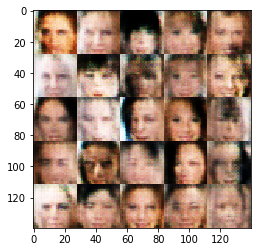

Epoch 0/1... Discriminator Loss: 1.0858... Generator Loss: 0.7635
Epoch 0/1... Discriminator Loss: 1.4583... Generator Loss: 0.5761
Epoch 0/1... Discriminator Loss: 1.5462... Generator Loss: 0.3569
Epoch 0/1... Discriminator Loss: 1.1549... Generator Loss: 0.7037
Epoch 0/1... Discriminator Loss: 1.2501... Generator Loss: 0.9212
Epoch 0/1... Discriminator Loss: 1.1037... Generator Loss: 0.7939
Epoch 0/1... Discriminator Loss: 1.0889... Generator Loss: 0.7418
Epoch 0/1... Discriminator Loss: 1.1353... Generator Loss: 0.9453
Epoch 0/1... Discriminator Loss: 1.0663... Generator Loss: 0.9979
Epoch 0/1... Discriminator Loss: 1.1950... Generator Loss: 1.0245


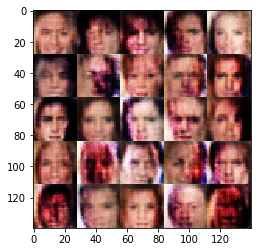

Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 0.8056
Epoch 0/1... Discriminator Loss: 1.2476... Generator Loss: 0.6668
Epoch 0/1... Discriminator Loss: 1.3232... Generator Loss: 0.9538
Epoch 0/1... Discriminator Loss: 1.2545... Generator Loss: 1.0888
Epoch 0/1... Discriminator Loss: 1.3102... Generator Loss: 0.5358
Epoch 0/1... Discriminator Loss: 1.1071... Generator Loss: 0.8909
Epoch 0/1... Discriminator Loss: 1.1267... Generator Loss: 0.9793
Epoch 0/1... Discriminator Loss: 1.0171... Generator Loss: 0.9279
Epoch 0/1... Discriminator Loss: 1.0835... Generator Loss: 0.8115
Epoch 0/1... Discriminator Loss: 1.1905... Generator Loss: 0.5851


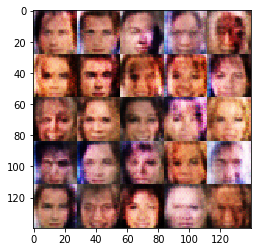

Epoch 0/1... Discriminator Loss: 1.3802... Generator Loss: 0.3982
Epoch 0/1... Discriminator Loss: 1.3085... Generator Loss: 2.1663
Epoch 0/1... Discriminator Loss: 1.3220... Generator Loss: 1.1951
Epoch 0/1... Discriminator Loss: 0.9702... Generator Loss: 0.7982
Epoch 0/1... Discriminator Loss: 1.0962... Generator Loss: 1.2401
Epoch 0/1... Discriminator Loss: 1.4784... Generator Loss: 0.3541
Epoch 0/1... Discriminator Loss: 1.4116... Generator Loss: 0.6572
Epoch 0/1... Discriminator Loss: 1.1670... Generator Loss: 0.7753
Epoch 0/1... Discriminator Loss: 1.0523... Generator Loss: 0.8643
Epoch 0/1... Discriminator Loss: 2.7137... Generator Loss: 0.1078


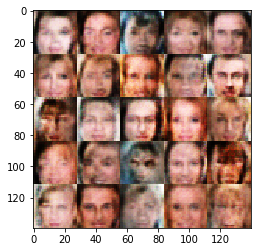

Epoch 0/1... Discriminator Loss: 1.1542... Generator Loss: 0.7774
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 0.7739
Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 0.7077
Epoch 0/1... Discriminator Loss: 1.6560... Generator Loss: 2.2453
Epoch 0/1... Discriminator Loss: 1.1749... Generator Loss: 0.5395
Epoch 0/1... Discriminator Loss: 1.2551... Generator Loss: 0.5548
Epoch 0/1... Discriminator Loss: 1.0633... Generator Loss: 1.0398
Epoch 0/1... Discriminator Loss: 1.7306... Generator Loss: 2.0551
Epoch 0/1... Discriminator Loss: 1.0600... Generator Loss: 0.9790
Epoch 0/1... Discriminator Loss: 0.9484... Generator Loss: 0.7047


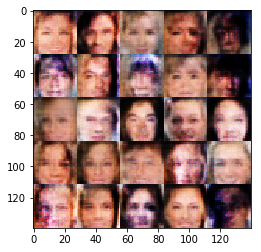

Epoch 0/1... Discriminator Loss: 1.5913... Generator Loss: 0.4235
Epoch 0/1... Discriminator Loss: 0.7913... Generator Loss: 2.0293
Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 0.8239
Epoch 0/1... Discriminator Loss: 1.2781... Generator Loss: 0.4735
Epoch 0/1... Discriminator Loss: 1.5216... Generator Loss: 0.3633
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 1.2367
Epoch 0/1... Discriminator Loss: 1.0198... Generator Loss: 1.2467
Epoch 0/1... Discriminator Loss: 1.5463... Generator Loss: 0.3441
Epoch 0/1... Discriminator Loss: 1.1887... Generator Loss: 1.1210
Epoch 0/1... Discriminator Loss: 1.2046... Generator Loss: 0.8576


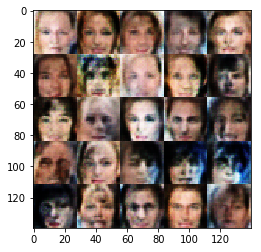

KeyboardInterrupt: 

In [23]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.